In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

### calcular a aceleração pela formula de Somigliana

In [2]:
a = 6378137.0
b = 6356752.3142
ga = 9.7803253359
gb = 9.8321849378

data = np.loadtxt('eigen-6c3stat-0_5-mundo.txt')
lon, lat, alt, gamma = data[:,0], data[:,1], data[:,2], data[:,3]

numerador = a * ga * np.cos(np.pi*lat/180)**2 + b*gb*np.sin(np.pi*lat/180)**2
denominador = np.sqrt(a**2 * (np.cos(np.pi*lat/180)**2) + b**2*(np.sin(np.pi*lat/180)**2))

somig = numerador/denominador

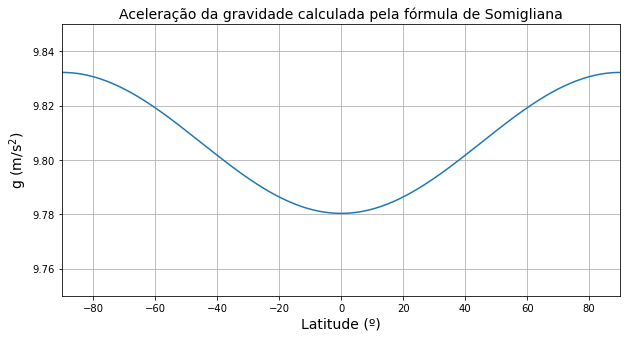

In [3]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(lat, somig)
ax.set_xlabel('Latitude (º)', fontsize=14)
ax.set_ylabel('g (m/s$^2$)', fontsize=14)
ax.set_title('Aceleração da gravidade calculada pela fórmula de Somigliana', fontsize=14)
ax.set_xlim([-90, 90])
ax.set_ylim([9.75, 9.85])
ax.grid()
plt.show()

**Explique o gráfico acima.** Quais fatores contribuem para este comportamento?

In [50]:
lat1

259560

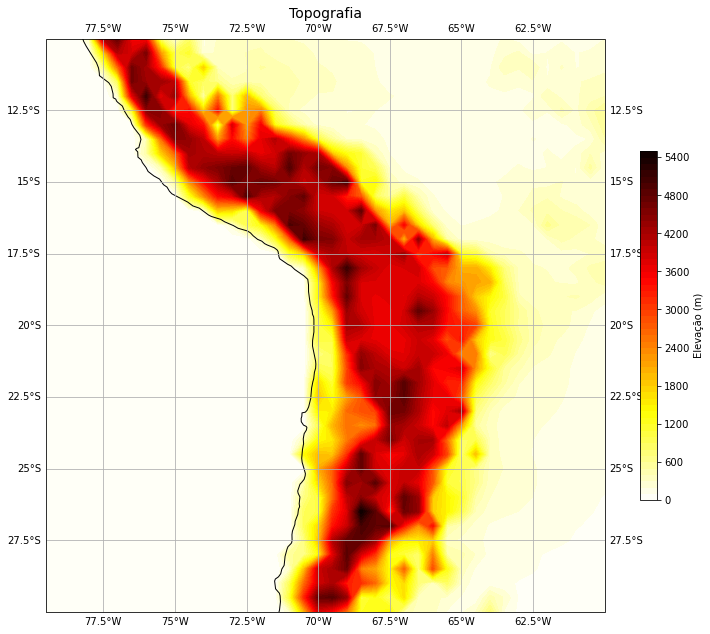

In [57]:
# minha seleção - está funcionando e é mais rápido do que plotar tudo e selecionar a área depois
data = np.loadtxt('eigen-6c3stat-0_5-mundo.txt')
#area = [15.0, -60.0, -90.0, -30.0]      # [lat_min, lat_max, lon_min, lon_max]    América do Sul
area = [-10.0, -30.0, -80.0, -60.0]    # [lat_min, lat_max, lon_min, lon_max]    América do Sul (zoom nos Andes)
#area = [60.0, 10.0, 50.0, 120.0]       # [lat_min, lat_max, lon_min, lon_max]    Himalaia

if area[2] < 0:
    area[2] = 360 + area[2]
if area[3] < 0:
    area[3] = 360 + area[3]

d_lat = 0.5
d_lon = 0.5

# seleciona latitudes
lat1 = np.abs(data[:,1]-area[0]).argmin()
lat2 = np.abs(data[:,1]-area[1] + d_lat).argmin()
data2 = data[lat1:lat2, :]

# seleciona longitudes
lon_inds = np.where((data2[:,0] > area[2]) & (data2[:,0] < (area[3] + d_lon)))
data3 = data2[lon_inds[0], :]

# reorganiza as informações
lon, lat, alt, gamma = data3[:,0], data3[:,1], data3[:,2], data3[:,3]
alt2 = np.reshape(alt, [int(np.abs(area[1]-area[0])/d_lat)+1, int(np.abs(area[3]-area[2])/d_lon)])
lon2 = lon[:int(np.abs(area[3]-area[2])/d_lon)]
lat2 = np.reshape(lat, [int(np.abs(area[1]-area[0])/d_lat)+1, int(np.abs(area[3]-area[2])/d_lon)])[:, 1]

# plota o mapa
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
z = plt.contourf(lon2, lat2, alt2, 60, transform=ccrs.PlateCarree(), cmap='hot_r')
plt.colorbar(z, ax=ax, label='Elevação (m)', shrink=0.5)

ax.coastlines(resolution='50m')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
ax.set_title('Topografia', fontsize=14)

plt.tight_layout()
plt.show()

# Mapa de Topografia

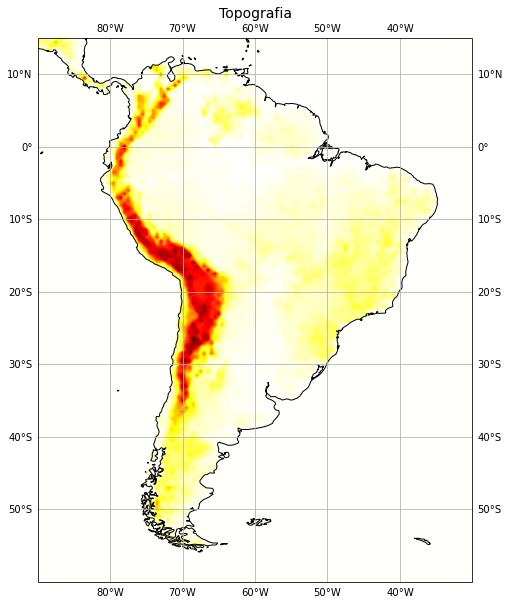

In [10]:
alt3 = np.reshape(alt, [361, 721])
lon3 = lon[:721]
lat3 = np.reshape(lat, [361, 721])[:, 1]


fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lon3, lat3, alt3, 120, transform=ccrs.PlateCarree(), cmap='hot_r')

ax.set_extent([-90, -30, 15, -60], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
ax.set_title('Topografia', fontsize=14)
ax.set_xlabel('Longitude (º)', fontsize=14)
ax.set_ylabel('Latitude (º)', fontsize=14)
plt.show()

In [6]:
(somig[-1]*1e5)   # conversão para mGal

983218.4937799999

In [7]:
gamma[-1]

982341.6437356794

In [9]:
gamma3 = np.reshape(gamma-(somig*1e5), [361, 721])
gamma3[-20:]

array([[-675.50268455, -680.66403394, -688.17315204, ..., -677.78872132,
        -677.26520281, -675.50268455],
       [-661.67033132, -671.37426233, -680.04859342, ..., -661.39181805,
        -661.71126345, -661.67033132],
       [-671.41939133, -676.4824266 , -680.71111297, ..., -663.78014747,
        -666.34168755, -671.41939133],
       ...,
       [-876.91615025, -877.40134231, -877.88257545, ..., -875.93522776,
        -876.42744274, -876.91615025],
       [-876.97329034, -877.01219378, -877.35776475, ..., -876.27619823,
        -876.31763602, -876.97329034],
       [-876.85004432, -876.85004432, -876.85004432, ..., -876.85004432,
        -876.85004432, -876.85004432]])

In [7]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lon3, lat3, gamma3, 60, transform=ccrs.PlateCarree(), cmap='hot_r')

ax.set_extent([-90, -30, 15, -60], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
ax.set_title('Distúrbio da gravidade', fontsize=14)
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000006C3207D550> (for post_execute):


KeyboardInterrupt: 